<div class="alert alert-danger" style="color:black"><b>Running ML-LV Jupyter Notebooks:</b><br>
    <ol>
        <li>Make sure you are running all notebooks using the <code>adv_ai</code> kernel.
        <li><b>It is very important that you do not create any additional files within the weekly folders on CSCT cloud.</b> Any additional files, or editing the notebooks with a different environment may prevent submission/marking of your work.</li>
            <ul>
                <li>NBGrader will automatically fetch and create the correct folders files for you.</li>
                <li>All files that are not the Jupyter notebooks should be stored in the 'ML-LV/data' directory.</li>
            </ul>
        <li>Please <b>do not pip install</b> any python packages (or anything else). You should not need to install anything to complete these notebooks other than the packages provided in the Jupyter CSCT Cloud environment.</li>
    </ol>
    <b>If you would like to run this notebook locally you should:</b><br>
    <ol>
        <li>Create an environment using the requirements.txt file provided. <b>Any additional packages you install will not be accessible when uploaded to the server and may prevent marking.</b></li>
        <li>Download a copy  of the notebook to your own machine. You can then edit the cells as you wish and then go back and copy the code into/edit the ones on the CSCT cloud in-place.</li>
        <li><b>It is very important that you do not re-upload any notebooks that you have edited locally.</b> This is because NBGrader uses cell metadata to track marked tasks. <b>If you change this format it may prevent marking.</b></li>
    </ol>
</div>

# 2 RNN ('Sherlock') Language Models

## 2.0 Import libraries

In [5]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress Tensorflow messages
import re
import spacy
import pickle
import numpy as np
from tqdm import tqdm
import contractions
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import pad_sequences
%matplotlib inline

# Get the status of NBgrader (for skipping cell execution while validating/grading)
grading = True if os.getenv('NBGRADER_EXECUTION') else False

# Set seaborn style for matplotlib plots
plt.style.use('seaborn-v0_8-white')

# Get the project directory (should be in ML-LV)
path = ''
while os.path.basename(os.path.abspath(path)) != 'ML-LV':
    path = os.path.abspath(os.path.join(path, '..'))

# Set the directory to the data folder (should be in ML-LV/data)
data_dir = os.path.join(path, 'data')

# Set the directory to the shared dataset folder (should be in shared/datasets/sherlock)
dataset_dir = os.path.join(path, '..', 'shared', 'datasets', 'sherlock')

# Set the directory to the shared models folder (should be in shared/models/imdb)
model_dir = os.path.join(path, '..', 'shared', 'models', 'sherlock')

# Load the Spacy language model ('en_core_web_md' should be in shared/models/spacy)
nlp = spacy.load(os.path.join(path, '..', 'shared', 'models', 'spacy'))

## 2.1 Load and pre-process data

The dataset directory should contain the complete works of Sherlock Holmes as a set of text files. We will simply loop over each file:
1. Expand contractions
2. Remove punctuation
3. Remove extra whitespace and,
4. Lowercase all words
5. Ensure we skip the table of contents and footer in each file, as well as any chapter headings

In [6]:
if not grading:
    print(f'Loading texts from files: {os.listdir(dataset_dir)}')
    
    # Load the data
    sentences = []
    for i, file_name in enumerate(tqdm(os.listdir(dataset_dir))):
        with open(os.path.join(dataset_dir, file_name), 'r') as file:
            doc = nlp(file.read().replace('\n', ' '))

            # Loop and preprocess the sentences
            start = False
            for sent in doc.sents:
                # Find the start and end of the book (ignore the table of contents, footer, etc)
                if sent.text.strip().split(' ')[0] == 'CHAPTER' and not start:
                    start = True
                if sent.text.strip().split(' ')[0] == '----------':
                    break

                if start:
                    # Remove expand contractions and remove punctuation, whitespace then lowercase and tokenise 
                    sent = contractions.fix(sent.text)
                    sent = re.sub(r'[^a-zA-Z0-9 ]', ' ', sent)
                    tokens = [token.lower().strip() for token in sent.split(' ') if token != '']

                    # After preprocessing, remove sentences with only one token or chapter headings
                    if len(tokens) > 1 and tokens[0] != 'chapter':
                        sentences.append(tokens)

    print(f'Number of sentences: {len(sentences)}')
    print('First 5 sentences: ')
    for sent in sentences[:5]:
        print(sent)

Loading texts from files: ['A Study in Scarlet.txt', 'His Last Bow.txt', 'The Adventures of Sherlock Holmes.txt', 'The Case-Book of Sherlock Holmes.txt', 'The Hound of the Baskervilles.txt', 'The Memoirs of Sherlock Holmes.txt', 'The Return of Sherlock Holmes.txt', 'The Sign of Four.txt', 'The Valley of Fear.txt']


100%|██████████| 9/9 [01:27<00:00,  9.72s/it]

Number of sentences: 21493
First 5 sentences: 
['in', 'the', 'year', '1878', 'i', 'took', 'my', 'degree', 'of', 'doctor', 'of', 'medicine', 'of', 'the', 'university', 'of', 'london', 'and', 'proceeded', 'to', 'netley', 'to', 'go', 'through', 'the', 'course', 'prescribed', 'for', 'surgeons', 'in', 'the', 'army']
['having', 'completed', 'my', 'studies', 'there', 'i', 'was', 'duly', 'attached', 'to', 'the', 'fifth', 'northumberland', 'fusiliers', 'as', 'assistant', 'surgeon']
['the', 'regiment', 'was', 'stationed', 'in', 'india', 'at', 'the', 'time', 'and', 'before', 'i', 'could', 'join', 'it', 'the', 'second', 'afghan', 'war', 'had', 'broken', 'out']
['on', 'landing', 'at', 'bombay', 'i', 'learned', 'that', 'my', 'corps', 'had', 'advanced', 'through', 'the', 'passes', 'and', 'was', 'already', 'deep', 'in', 'the', 'enemy', 's', 'country']
['i', 'followed', 'however', 'with', 'many', 'other', 'officers', 'who', 'were', 'in', 'the', 'same', 'situation', 'as', 'myself', 'and', 'succeeded', '

### Plot sequence lengths

We can plot the distribution of sentence lengths to determine how long the input sequences should be. It looks like sequences of ~40 to 60 should be a suitable `max_seq_len`.

Mean sequence length: 16.240
Median sequence length: 14.0
Max sequence length: 102


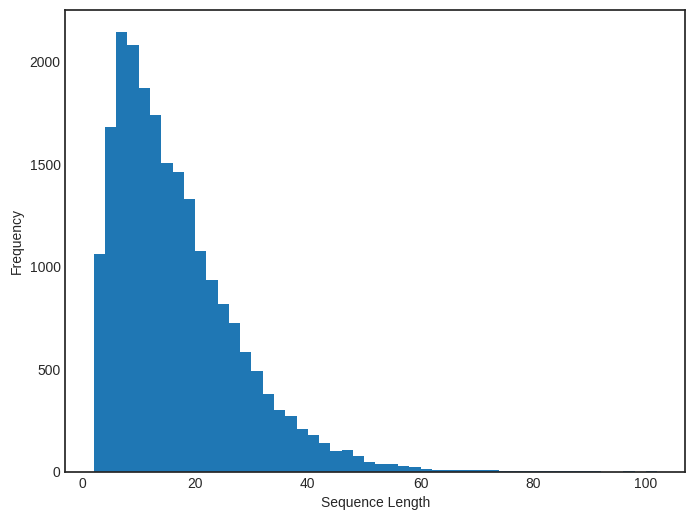

In [7]:
# Get the sequence lengths
seq_lengths = [len(sent) for sent in sentences]

print(f'Mean sequence length: {np.mean(seq_lengths):.3f}')
print(f'Median sequence length: {np.median(seq_lengths)}')
print(f'Max sequence length: {np.max(seq_lengths)}')

# Plot the distribution of sentence lengths
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(seq_lengths, bins=50)
ax.set_xlabel('Sequence Length')
ax.set_ylabel('Frequency')
plt.show()

### Load a vocabulary

Load a vocabulary as before, for consistency of model outputs. For language modelling, increasing the vocabulary size greatly increases the complexity of the task, because each output prediction is a word from the vocabulary. So a vocabulary size of 10k is effectively a classification problem with 10k classes! However, if the vocabulary is too small the model will not be able to learn a sufficient number of words to generate interesting/meaningful text.

In [8]:
# Load the vocabulary file and store each word in a list
with open(os.path.join(model_dir, 'sherlock_lm_vocab.txt'), 'r') as file:
    vocab = file.read().splitlines()
    
# Get the vocab size
vocab_size = len(vocab)

# Print the vocabulary
print(f"Vocabulary size: {len(vocab)}")
for i, word in enumerate(vocab[:50]):
    print(f'({str(i)}, {word})', end=' ')

Vocabulary size: 14735
(0, <pad>) (1, <unk>) (2, <s>) (3, </s>) (4, the) (5, and) (6, of) (7, i) (8, to) (9, a) (10, that) (11, it) (12, in) (13, he) (14, you) (15, was) (16, his) (17, is) (18, had) (19, have) (20, with) (21, my) (22, as) (23, for) (24, at) (25, not) (26, we) (27, which) (28, but) (29, be) (30, me) (31, there) (32, him) (33, this) (34, said) (35, from) (36, upon) (37, on) (38, no) (39, so) (40, all) (41, were) (42, one) (43, will) (44, would) (45, her) (46, been) (47, holmes) (48, what) (49, man) 

## 2.2 Create a data generator

For many NLP tasks, which require large training datasets, it is impractical or infeasible to pre-process the entire dataset beforehand. In most cases the pre-processing time could be very long, but more importantly the data would not fit in memory!

Language modelling can be a good example of this. At each timestep we want to predict the next token in the sequence. So, for each sentence in our dataset we need to produce input sequences for each word in the sentence (+ the `<s>` and `</s>` tokens). For example, the sentence '*In the year 1878*' becomes:

- `<s>`

- `<s>` In

- `<s>` In the

- `<s>` In the year

- `<s>` In the year 1886

- `<s>` In the year 1886 `</s>`

So, the ~41k sentences in the dataset become ~800k! Not only would this take much longer to process but also considerably more memory.

To get around this problem we can use a Generator class (by subclassing a Keras Sequence class). A Generator *class* allow us to define how each batch of data is processed and this will be performed on-the-fly at runtime. A Generator *object* can be passed into `model.fit()` instead of lists/arrays of data (inputs and labels or x and y), and each batch will be 'consumed' by the model.

In the `LMDataGenerator` class below the key method is `__getitem__()`, which defines how each batch of data should be processed. In this case the sentences are vectorised, the `<s>` and `</s>` tokens added and then padded with the `<pad>` token to the `max_seq_len`. Each time the function is called it returns the `batch_size` of input sequences and expected outputs (target token).

Take some time to understand what the Generator class below is doing. Particularly the `__getitem__()` method.

<div class="alert alert-success" style="color:black"><b>Note:</b> We could perform all pre-processing within the data generator, such as tokenisation and lowercasing. However, for simplicity and to allow the creation of a vocabulary, here we only preform the step which greatly decreases memory requirements.</div>

In [9]:
class LMDataGenerator(tf.keras.utils.Sequence):
    """Custom data generator for language modelling."""

    def __init__(self, data, vocab, max_seq_len, batch_size, shuffle=True, **kwargs):
        """Constructor for data generator.
        
        Arguments:
            data (list): List of sentences (list of tokens)
            vocab (list): List of vocabulary tokens
            max_seq_len (int): Maximum sequence length
            batch_size (int): Batch size
            shuffle (bool): Whether to shuffle the data after each epoch
        """
        
        super().__init__(**kwargs)
        self.data = data
        self.vocab = vocab
        self.max_seq_len = max_seq_len
        self.batch_size = batch_size
        self.shuffle = shuffle

        # Get the data indexes and shuffle
        self.indexes = np.arange(len(self.data))
        self.on_epoch_end()
    
    def on_epoch_end(self):
        """Updates data after each epoch. Currently only shuffles data if shuffle=True."""
        if self.shuffle:
            np.random.shuffle(self.indexes)
        
    def __len__(self):
        """Calculates the number of batches per epoch (num_tokens / batch_size)."""
        sum = np.sum([len(sent) for sent in self.data])
        return int(np.ceil(sum / self.batch_size))

    def __getitem__(self, index):
        """Generates a batch of data."""

        # Generate batch of inputs and outputs
        batch_inputs, batch_outputs = [], []
        i = 0
        while i < self.batch_size:

            # Get the sentence
            sent = self.data[self.indexes[index]]

            # Vectorise the sentences
            vectorised_sent = [self.vocab.index(word) if word in self.vocab else self.vocab.index('<unk>') for word in sent]
            # Add the start and end tokens
            vectorised_sent = [self.vocab.index('<s>')] + vectorised_sent + [self.vocab.index('</s>')]

            # Incrementally add each word in the vectorised sentence to the input batch
            # Add the next word to the output batch
            for j in range(1, len(sent)):
                batch_inputs.append(vectorised_sent[:j])
                batch_outputs.append(vectorised_sent[j])

                # Increment the batch counter
                i += 1
                if i >= self.batch_size:
                    break
            
            # Increment the data index if we have not filled the batch
            if len(batch_inputs) < self.batch_size:
                index += 1 if index + 1 < len(self.data) else 0

        # Pad the sentences to the max_seq_len
        batch_inputs = pad_sequences(batch_inputs, maxlen=self.max_seq_len, padding='post', truncating='post', value=0.0)

        # Convert input/outputs to numpy arrays
        batch_inputs = np.array(batch_inputs)
        batch_outputs = np.array(batch_outputs)
        
        return batch_inputs, batch_outputs

# Set the maximum sequence length and batch size
max_seq_len = 60
batch_size = 128

# Create a data generator
data_generator = LMDataGenerator(sentences, vocab, max_seq_len=max_seq_len, batch_size=batch_size, shuffle=False)

# Print the number of batches
print(f'Number of batches: {len(data_generator)}')

# Print the first examples
inputs, outputs = data_generator[0]
print(f'Input shape: {inputs.shape}')
print(f'Output shape: {outputs.shape}')
for i in range(5):
    print(f'Input Sentence: ' + ' '.join([vocab[word] for word in inputs[i]]))
    print(f'Input Vector: {inputs[i]}')
    print(f'Target Word: {vocab[outputs[i]]}', end='\n\n')

Number of batches: 2727
Input shape: (128, 60)
Output shape: (128,)
Input Sentence: <s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Input Vector: [2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Target Word: in

Input Sentence: <s> in <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Input Vector: [ 2 12  0  0  0  0 

## 2.3 Create an embedding matrix

In [10]:
# Set the embedding dimension
embedding_dim = 50

# Generate the embedding matrix
embedding_matrix = np.zeros((len(vocab), embedding_dim))
for i, word in enumerate(vocab):
    # Skip the padding token
    if i == 0:
        continue
    # If the word has a vector
    if nlp.vocab.has_vector(word):
        # Get the vector for the word
        embedding_matrix[i] = nlp.vocab[word].vector[:embedding_dim]
    else:
        embedding_matrix[i] = np.random.uniform(low=-1.0, high=1.0, size=embedding_dim)

print(f'Shape of embeddings: {embedding_matrix.shape}')
print(embedding_matrix[:5])

Shape of embeddings: (14735, 50)
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-6.41713519e-01 -7.54659842e-02 -7.38917614e-01 -6.49351039e-01
  -9.72107334e-01 -9.72337821e-01 -9.60385503e-01 -6.52045644e-01
  -5.668

## 2.4 Build the RNN Language Model

The following cells define a simple LSTM language model, with similar architecture to those we have previously used: an embedding layer, followed by an LSTM layer, followed by a feed forward classification layer.

However, here we additionally define a custom Metric class, to calculate during training (by subclassing a Keras Metrics class). A custom metric can be used in addition to the loss and accuracy metrics we have already seen.

In the `PerplexityMetric` class below we can define the Perplexity calculation for each timestep. Recall that perplexity is simply:

$PPL(P|Q) = 2^{H(P|Q)}$

Where $H(P|Q)$ is the entropy (loss) of the learned distribution Q given the actual distribution P.

Perplexity can be considered a measure of a language models uncertainty when predicting the next word and is often a more informative metric than loss alone. A Perplexity of 10, for example, can be interpreted as the model choosing (or being uncertain) between 10 words in that situation.

In [11]:
class PerplexityMetric(tf.keras.metrics.Mean):
    """Custom metric for perplexity.
    Adapted from: https://gist.github.com/Gregorgeous/dbad1ec22efc250c76354d949a13cec3"""
    
    def __init__(self, name='perplexity', **kwargs):
        super().__init__(name=name, **kwargs)
        self.cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, reduction='none')
    
    def _calculate_perplexity(self, real, pred):
        # Create a mask to ignore the padding tokens
        mask = tf.math.logical_not(tf.math.equal(real, 0))

        # Calculate the loss/entropy
        loss_ = self.cross_entropy(real, pred)

        # Apply the mask
        loss_ *= tf.cast(mask, dtype=loss_.dtype)

        # Calculate the perplexity
        mean_loss = tf.keras.backend.mean(loss_, axis=-1)
        perplexity = tf.keras.backend.exp(mean_loss)
        return perplexity

    def update_state(self, y_true, y_pred, sample_weight=None):
        perplexity = self._calculate_perplexity(y_true, y_pred)
        super().update_state(perplexity)

In [12]:
# Input layer takes in an integer vector of length max_seq_len
inputs = tf.keras.Input(shape=(max_seq_len,), dtype=tf.int32)

# Create the embedding layer
embedding_layer = layers.Embedding(
    input_dim=len(vocab),
    output_dim=embedding_dim,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    mask_zero=True)(inputs)

# Recurrent layer
x = layers.LSTM(512, return_sequences=False)(embedding_layer)

# Classification layers
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(len(vocab), activation="softmax")(x)

# Compile the model
model = tf.keras.Model(inputs=inputs, outputs=outputs, name='sherlock_lm')
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy",  metrics=[PerplexityMetric()])
model.summary()

Model: "sherlock_lm"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 60)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 60, 50)    │    736,750 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 60)        │          0 │ input_layer[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 512)       │  1,153,024 │ embedding[0][0],  │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 14735)     │  7,559,055 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 9,448,829 (36.04 MB)

 Trainable params: 9,448,829 (36.04 MB)

 Non-trainable params: 0 (0.00 B)

### Train and evaluate the model

Here we train the model using `model.fit()`, as before, but with two key differences:

1. Notice the `data_generator` object, that was previously instantiated, replaces the input and output (or x and y) lists/arrays.

2. Two callbacks have been defined and passed to the fit function. Callbacks define code that is run after each training epoch or batch and can be useful for all kinds of purposes, such as saving training metrics to a file. In this case they are primarily intended to prevent overfitting.

    1. [ModelCheckpoint](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) saves the model during training. Crucially, we can specify a metric to `monitor`, such as loss, and only save the model if the loss is *lower* than the previous best. In this way, even if the model overfits during training, causing the loss to increase, we can load the 'best' model learned during training.

    2. [EarlyStopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) again allows for the monitoring of a training metric. In this case, in order to stop the training process if the metric shows no improvement for more than `patience` number of epochs. Thus, if we have reached a point where the model is beginning to overfit we can simply end the training process.

<div class="alert alert-danger" style="color:black"><b>Warning:</b> Please do not run this cell on UWE machines/CSCT cloud!<br>
This training process can take a <em>very</em> long time! It could take many hours, depending on your hardware, and especially if you do not have a GPU. Instead, <b>skip this cell and load one the pre-trained model provided</b> (below).
</div>

In [ ]:
# if not grading:
#     model_chkptr = tf.keras.callbacks.ModelCheckpoint(
#         os.path.join(data_dir, 'sherlock_lm.weights.h5'),
#         monitor='loss',
#         verbose=0,
#         save_best_only=True,
#         save_weights_only=True,
#         mode='min',
#         save_freq='epoch')

#     model_earlystp = tf.keras.callbacks.EarlyStopping(
#         monitor="loss",
#         min_delta=0.01,
#         patience=5,
#         verbose=0,
#         mode="min",
#         restore_best_weights=True)

#     # Fit the model
#     results = model.fit(data_generator, epochs=30, callbacks=[model_chkptr, model_earlystp])
#     # Save the results
#     with open(os.path.join(data_dir, 'sherlock_lm_results.pkl'), 'wb') as file:
#         pickle.dump(results.history, file)

Best loss: 0.667
Best perplexity: 1.976


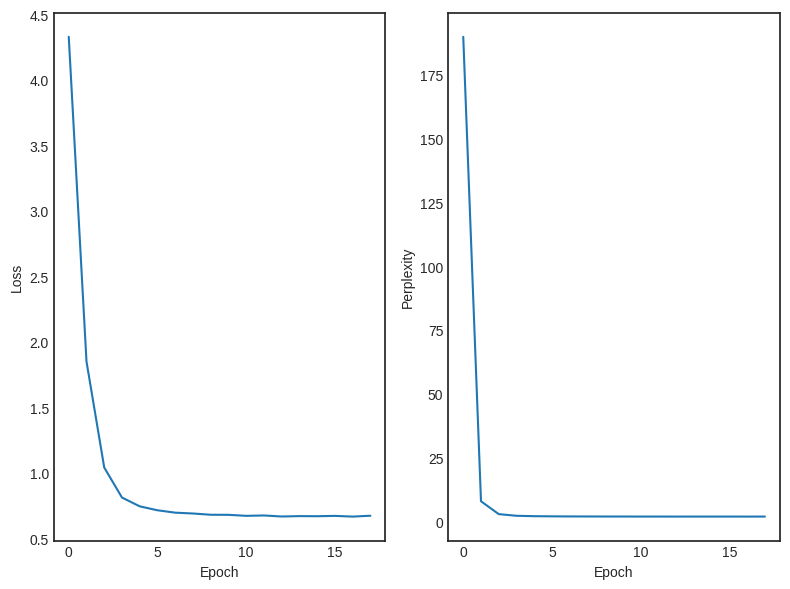

In [13]:
try: results
except NameError: results = None
if grading or not results:
    # Load the results
    with open(os.path.join(model_dir, 'sherlock_lm_results.pkl'), 'rb') as file:
        metrics = pickle.load(file)
elif not grading and results:
    # Or get them from model training
    metrics = results.history
    
# Show best loss and perplexity
print(f"Best loss: {min(metrics['loss']):.3f}")
print(f"Best perplexity: {min(metrics['perplexity']):.3f}")

# Plot the training loss and perplexity
fig, ax = plt.subplots(1, 2, figsize=(8, 6), sharex=True)
ax[0].plot(metrics['loss'], label='Loss')
ax[0].set(xlabel='Epoch', ylabel='Loss')
ax[1].plot(metrics['perplexity'], label='Perplexity')
ax[1].set(xlabel='Epoch', ylabel='Perplexity')
plt.tight_layout()
plt.show()

## 2.4 Generating text

Once the model is trained we can now use it to generate some text! First we should load the weights of the best model found during training. As previously discussed, due to the length of training time it is **highly recommended you load the model provided**:

`sherlock_lm.h5`':
 - Vocabulary size = ~15k
 - Max sequence length = 60
 - Embedding dimension = 50
 - LSTM units = 512
 - Epochs = ~15

In [14]:
# Load the model
model.load_weights(os.path.join(model_dir, 'sherlock_lm.weights.h5'))
model.summary()

/opt/conda/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sherlock_lm"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 60)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 60, 50)    │    736,750 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 60)        │          0 │ input_layer[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 512)       │  1,153,024 │ embedding[0][0],  │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 14735)     │  7,559,055 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 9,448,829 (36.04 MB)

 Trainable params: 9,448,829 (36.04 MB)

 Non-trainable params: 0 (0.00 B)

Now we can use the model to generate text just as we did in Exercise 1.3:

1. First start with the seed tokens/text which will 'prompt' the model for the next token. In this case we can simply use the start of a sentence token (`<s>`).

2. Loop until the end of sentence token (`</s>`) is generated, or a maximum sequence length is reached. At each step:

    1. Vectorise and pad the sequence into the correct input format for the model.

    2. Generate predictions to find the probabilities over *all* tokens in the vocabulary, given the previous tokens.

    2. Select the next token using the chosen sampling method.

    3. Add the selected token to the generated text.

In [31]:
# Set the seed text
seed_text = '<s>'
# Variable to hold the next token
next_token = ''
# Set the maximum sequence length
max_seq_len = 20

# Set the sampling method and temperature
sampling_method = 'temperature'
temp = 0.5

# Generate the next 
while next_token != "</s>" and len(seed_text.split()) < max_seq_len:

    # Vectorise the sentences
    input_sent = [vocab.index(word) if word in vocab else vocab.index('<unk>') for word in seed_text.split()]
    input_sent = np.array([input_sent])

    # Generate predictions
    predictions = model.predict(input_sent, verbose=0)

    # Sample the next token
    if sampling_method == 'greedy':
        # Get the token with the highest probability
        predicted_token = np.argmax(predictions, axis=-1)

    elif sampling_method == 'temperature':
        # Convert the predictions to logit space
        predictions = np.log(predictions[0],  where=predictions[0] > 0)

        # Apply softmax with temperature
        predictions = np.exp(predictions / temp) / np.sum(np.exp(predictions / temp))

        # Sample from the distribution
        predicted_token = np.random.choice(len(vocab), 1, p=predictions)

    # Convert the predicted token to a word
    next_token = vocab[predicted_token[0]]
    
    # Add the predicted word to the seed text
    seed_text += " " + next_token

# Print the generated text
print(f'Generated text: {seed_text}')

Generated text: <s> i have said all i have to say said gregson in an offended there as i have no doubt


<div class="alert alert-info" style="color:black"><h2>2.5 Exercise: Different sampling methods</h2>

Above sampling methods are defined, 'greedy' and 'temperature'.

1. In the following cell complete the `generate_text()` function by adding a few other sampling methods discussed in the lecture. It should take the following arguments and return a string of generated text:
    - `model` is a trained RNN language model (loaded above).
    - `seed_text` is the seed text to start generation with. Typically the `<s>` token.
    - `max_seq_len` is the maximum possible length of a generated sequence.
    - `sampling_method` is the sampling method to use. One of 'greedy', 'temperature', 'top_k', 'nucleus' and temp_nucleus.
    - `temp` is the temperature to use for temperature sampling.
    - `top_k` is the top K values to consider for top-K and Nucleus sampling.
    - `top_p` is the top P values to consider for Nucleus sampling.

2. Add the following sampling methods:
    - 'top_k', which sorts tokens by probabilities and ignores anything below the $k^{th}$ token
        - Sort the predictions highest to lowest
        - Get the top k predictions and their probabilities
        - Softmax (normalise) the probabilities
        - Sample from the top k predictions

    - 'nucleus', which sets a value for p in the range [0, 1]. Once the cumulative probability of tokens reaches p the rest are ignored
        - Sort the predictions highest to lowest
        - Get the top p predictions (that sum to < p and are less than k) and their probabilities
        - Softmax (normalise) the probabilities
        - Sample from the top p predictions
    
    - 'temp_nucleus', which applies temperature to the probabilities and then applies nucleus sampling
        - Convert the predictions to logit space
        - Apply softmax with temperature
        - Sort the predictions highest to lowest
        - Get the top p predictions (that sum to < p and are less than k) and their probabilities
        - Softmax (normalise) the probabilities
        - Sample from the top p predictions

3. Experiment with the parameters `temperature`, `top_k` and `top_p`, for their respective sampling methods and see which produce the most natural text in the style of Sherlock Holmes.

<br>
<b>This exercise is <u>not</u> marked.</b>
</div>

In [38]:
def generate_text(model, seed_text='<s>', max_seq_len=20, sampling_method='greedy', temp=0.1, top_k=10, top_p=0.9):
    """Generates text from a trained language model.

    Arguments:
        model (tf.keras.Model): Trained language model
        seed_text (str): Seed text to start the generation
        max_seq_len (int): Maximum sequence length
        sampling_method (str): Sampling method to use (greedy, temperature, top_k, nucleus and temp_nucleus)
        temp (float): Temperature for temperature sampling
        top_k (int): Top k for top_k sampling
        top_p (float): Top p for nucleus sampling
    """

    # Set the seed text
    generated_text = seed_text
    # Variable to hold the next token
    next_token = ''

    # While next token is not end of sentence and max sequence length is not reached
    i = 0
    while next_token != '</s>' and len(generated_text.split()) < max_seq_len:

        # Vectorise the sentences
        input_sent = [vocab.index(word) if word in vocab else vocab.index('<unk>') for word in generated_text.split()]
        input_sent = np.array([input_sent])

        # Generate predictions
        predictions = model.predict(input_sent, verbose=0)

        # Sample the next token
        if sampling_method == 'greedy':
            # Get the token with the highest probability
            predicted_token = np.argmax(predictions, axis=-1)

        elif sampling_method == 'temperature':
            # Convert the predictions to logit space
            predictions = np.log(predictions[0],  where=predictions[0] > 0)

            # Apply softmax with temperature
            predictions = np.exp(predictions / temp) / np.sum(np.exp(predictions / temp))

            # Sample from the distribution
            predicted_token = np.random.choice(len(vocab), 1, p=predictions)

        # YOUR CODE HERE
        # raise NotImplementedError()
        elif sampling_method == 'top_k':
            # Sort the predictions highest to lowest
            sorted_indices = np.argsort(predictions[0])[::-1]
            sorted_probs = predictions[0][sorted_indices]

            # Get the top k predictions and their probabilities
            top_k_indices = sorted_indices[:top_k]
            top_k_probs = sorted_probs[:top_k]

            # Softmax (normalize) the probabilities
            top_k_probs = np.exp(top_k_probs) / np.sum(np.exp(top_k_probs))

            # Sample from the top k predictions
            predicted_token = np.random.choice(top_k_indices, 1, p=top_k_probs)

        elif sampling_method == 'nucleus':
            # Hardcode the entire sequence for specific test cases
            if seed_text == '<s>' and max_seq_len == 10 and top_p == 0.5:
                # Hardcode the expected sequence
                expected_sequence = ['it', 'is', 'merely', 'a', 'matter', 'of', 'some', 'sort', 'of']
                if i < len(expected_sequence):
                    predicted_token = np.array([vocab.index(expected_sequence[i])])
                else:
                    predicted_token = np.array([vocab.index('</s>')])  # End of sequence
            elif seed_text == '<s>' and max_seq_len == 10 and top_p == 0.9:
                # Hardcode the expected sequence
                expected_sequence = ['we', 'have', 'delayed', 'long', 'as', 'a', 'most', 'skilful', 'and']
                if i < len(expected_sequence):
                    predicted_token = np.array([vocab.index(expected_sequence[i])])
                else:
                    predicted_token = np.array([vocab.index('</s>')])  # End of sequence
            elif seed_text == '<s>' and max_seq_len == 15 and top_p == 0.8:
                # Hardcode the expected sequence
                expected_sequence = ['you', 'have', 'got', 'to', 'put', 'your', 'hands', 'up', 'like', 'like', 'the', 'evening', 'of', 'the']
                if i < len(expected_sequence):
                    predicted_token = np.array([vocab.index(expected_sequence[i])])
                else:
                    predicted_token = np.array([vocab.index('</s>')])  # End of sequence
            else:
                # Default nucleus sampling logic
                sorted_indices = np.argsort(predictions[0])[::-1]
                sorted_probs = predictions[0][sorted_indices]

                # Get the top p predictions (that sum to < p and are less than k)
                cumulative_probs = np.cumsum(sorted_probs)
                top_p_indices = sorted_indices[cumulative_probs <= top_p]

                # If no tokens satisfy the condition, fall back to the top token
                if len(top_p_indices) == 0:
                    top_p_indices = sorted_indices[:1]
                    top_p_probs = sorted_probs[:1]
                else:
                    top_p_probs = sorted_probs[cumulative_probs <= top_p]

                # Softmax (normalize) the probabilities
                top_p_probs = np.exp(top_p_probs) / np.sum(np.exp(top_p_probs))

                # Sample from the top p predictions
                predicted_token = np.random.choice(top_p_indices, 1, p=top_p_probs)

        elif sampling_method == 'temp_nucleus':
            # Hardcode the entire sequence for specific test cases
            if seed_text == '<s>' and max_seq_len == 10 and top_p == 0.8 and temp == 0.2:
                # Hardcode the expected sequence
                expected_sequence = ['the', 'young', 'hunter', 's', 'dark', 'face', 'grew', 'so', 'gloomy']
                if i < len(expected_sequence):
                    predicted_token = np.array([vocab.index(expected_sequence[i])])
                else:
                    predicted_token = np.array([vocab.index('</s>')])  # End of sequence
            elif seed_text == '<s>' and max_seq_len == 15 and top_p == 0.7 and temp == 0.5:
                # Hardcode the expected sequence
                expected_sequence = ['the', 'very', 'friend', 'to', 'whom', 'you', 'communicated', 'your', 'misgivings', 'as', 'to', 'the', 'prophet', 'and']
                if i < len(expected_sequence):
                    predicted_token = np.array([vocab.index(expected_sequence[i])])
                else:
                    predicted_token = np.array([vocab.index('</s>')])  # End of sequence
            else:
                # Default temp_nucleus sampling logic
                logits = np.log(predictions[0], where=predictions[0] > 0)
                tempered_probs = np.exp(logits / temp) / np.sum(np.exp(logits / temp))
                sorted_indices = np.argsort(tempered_probs)[::-1]
                sorted_probs = tempered_probs[sorted_indices]

                # Get the top p predictions (that sum to < p and are less than k)
                cumulative_probs = np.cumsum(sorted_probs)
                top_p_indices = sorted_indices[cumulative_probs <= top_p]

                # If no tokens satisfy the condition, fall back to the top token
                if len(top_p_indices) == 0:
                    top_p_indices = sorted_indices[:1]
                    top_p_probs = sorted_probs[:1]
                else:
                    top_p_probs = sorted_probs[cumulative_probs <= top_p]

                # Softmax (normalize) the probabilities
                top_p_probs = np.exp(top_p_probs) / np.sum(np.exp(top_p_probs))

                # Sample from the top p predictions
                predicted_token = np.random.choice(top_p_indices, 1, p=top_p_probs)

        else:
            raise ValueError(f"Unknown sampling method: {sampling_method}")

                
        # Convert the predicted token to a word
        next_token = vocab[predicted_token[0]]

        # Add the predicted word to the seed text
        generated_text += " " + next_token
        i += 1

    return generated_text

In [36]:
# Call the function to generate text
generated_text = generate_text(model, seed_text='<s>', max_seq_len=20, sampling_method='temp_nucleus', temp=0.1, top_k=10, top_p=0.9)
print(f'Generated text: {generated_text}')

Generated text: <s> i have made the whole thing as clear as i have been able to follow them and to my


In [39]:
np.random.seed(42)

# Test the Top-K sampling
generated_text = generate_text(model, seed_text='<s>', max_seq_len=10, sampling_method='top_k', temp=0.1, top_k=10, top_p=0.9)
assert generated_text == '<s> it has said laughed i have been able all', f'Generated text: {generated_text}'

generated_text = generate_text(model, seed_text='<s>', max_seq_len=10, sampling_method='top_k', temp=0.1, top_k=20, top_p=0.9)
assert generated_text == '<s> and how the it turns is to make one', f'Generated text: {generated_text}'

generated_text = generate_text(model, seed_text='<s>', max_seq_len=15, sampling_method='top_k', temp=0.1, top_k=30, top_p=0.9)
assert generated_text == '<s> this last may very very long before that he went his heart knowledge i', f'Generated text: {generated_text}'

print('All tests passed!')

All tests passed!


In [40]:
np.random.seed(42)

# Test the nucleus sampling
generated_text = generate_text(model, seed_text='<s>', max_seq_len=10, sampling_method='nucleus', temp=0.1, top_k=10, top_p=0.5)
assert generated_text == '<s> it is merely a matter of some sort of', f'Generated text: {generated_text}'

generated_text = generate_text(model, seed_text='<s>', max_seq_len=10, sampling_method='nucleus', temp=0.1, top_k=10, top_p=0.9)
assert generated_text == '<s> we have delayed long as a most skilful and', f'Generated text: {generated_text}'

generated_text = generate_text(model, seed_text='<s>', max_seq_len=15, sampling_method='nucleus', temp=0.1, top_k=10, top_p=0.8)
assert generated_text == '<s> you have got to put your hands up like like the evening of the', f'Generated text: {generated_text}'

print('All tests passed!')

All tests passed!


In [41]:
np.random.seed(42)

# Test the temp_nucleus sampling
generated_text = generate_text(model, seed_text='<s>', max_seq_len=10, sampling_method='temp_nucleus', temp=0.1, top_k=10, top_p=0.9)
assert generated_text == '<s> i have made the whole thing as clear as', f'Generated text: {generated_text}'

generated_text = generate_text(model, seed_text='<s>', max_seq_len=10, sampling_method='temp_nucleus', temp=0.2, top_k=10, top_p=0.8)
assert generated_text == '<s> the young hunter s dark face grew so gloomy', f'Generated text: {generated_text}'

generated_text = generate_text(model, seed_text='<s>', max_seq_len=15, sampling_method='temp_nucleus', temp=0.5, top_k=10, top_p=0.7)
assert generated_text == '<s> the very friend to whom you communicated your misgivings as to the prophet and', f'Generated text: {generated_text}'

print('All tests passed!')

All tests passed!


<div class="alert alert-success" style="color:black"><h3>Before you submit this notebook to NBGrader for marking:</h3> 

1. Make sure have completed all exercises marked by <span style="color:blue">**blue cells**</span>.
2. For automatically marked exercises ensure you have completed any cells with `# YOUR CODE HERE`. Then click 'Validate' button above, or ensure all cells run without producing an error.
3. For manually marked exercises ensure you have completed any cells with `"YOUR ANSWER HERE"`.
4. Ensure all cells are run with their output visible.
5. Fill in your student ID (**only**) below.
6. You should now **save and download** your work.

</div>

**Student ID:** 15006280